In [1]:
import kagglehub

path = kagglehub.dataset_download("niravnaik/safety-helmet-and-reflective-jacket")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/safety-helmet-and-reflective-jacket


In [2]:
import shutil

src = "/kaggle/input/safety-helmet-and-reflective-jacket/safety-Helmet-Reflective-Jacket"
dst = "/kaggle/working/datasets/ppe"
shutil.copytree(src, dst)
print("Dataset copied to:", dst) 

Dataset copied to: /kaggle/working/datasets/ppe


In [3]:
import os

dataset_path = "/kaggle/working/datasets/ppe"

print("=== DIRECTORY TREE (FOLDERS ONLY) ===\n")

for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for d in dirs:
        subindent = " " * 4 * (level + 1)
        print(f"{subindent}{d}/")


=== DIRECTORY TREE (FOLDERS ONLY) ===

ppe/
    train/
    test/
    valid/
    train/
        images/
        labels/
        images/
        labels/
    test/
        images/
        labels/
        images/
        labels/
    valid/
        images/
        labels/
        images/
        labels/


In [4]:
import os
import shutil

base_path = "/kaggle/working/datasets/ppe"

target_path = "/kaggle/working/datasets/ppe_clean"
os.makedirs(target_path, exist_ok=True)

for folder in ["images", "labels"]:
    for split in ["train", "valid", "test"]:
        # Create target folders
        os.makedirs(f"{target_path}/{folder}/{split}", exist_ok=True)
        # Source: pick the first images/labels folder inside each split
        src = os.path.join(base_path, split, folder)
        dst = f"{target_path}/{folder}/{split}"
        # Move files
        for f in os.listdir(src):
            shutil.move(os.path.join(src, f), dst)

# Optionally, remove remaining duplicate folders
for split in ["train", "valid", "test"]:
    split_path = os.path.join(base_path, split)
    for sub in os.listdir(split_path):
        sub_path = os.path.join(split_path, sub)
        if os.path.isdir(sub_path):
            try:
                shutil.rmtree(sub_path)
            except:
                pass

print("Dataset cleaned and moved to YOLO structure at:", target_path)


Dataset cleaned and moved to YOLO structure at: /kaggle/working/datasets/ppe_clean


In [5]:
import os

dataset_path = "/kaggle/working/datasets/ppe"  

print("=== DIRECTORY TREE (FOLDERS ONLY) ===\n")

for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    for d in dirs:
        subindent = " " * 4 * (level + 1)
        print(f"{subindent}{d}/")


=== DIRECTORY TREE (FOLDERS ONLY) ===

ppe/
    train/
    test/
    valid/
    train/
    test/
    valid/


In [6]:
import yaml
import os

# Path to save YAML
yaml_path = "/kaggle/working/datasets/ppe_clean/data.yaml"

# Define YAML content
data_dict = {
    "train": "/kaggle/working/datasets/ppe_clean/images/train",
    "val": "/kaggle/working/datasets/ppe_clean/images/valid",
    "test": "/kaggle/working/datasets/ppe_clean/images/test",
    "nc": 2,
    "names": ["Helmet", "Vest"]
}

# Save YAML
with open(yaml_path, "w") as f:
    yaml.dump(data_dict, f)

print("data.yaml saved at:", yaml_path)


data.yaml saved at: /kaggle/working/datasets/ppe_clean/data.yaml


In [7]:
import yaml

yaml_path = "/kaggle/working/datasets/ppe_clean/data.yaml"

with open(yaml_path) as f:
    data = yaml.safe_load(f)

print("Contents of data.yaml:")
print(data)

Contents of data.yaml:
{'names': ['Helmet', 'Vest'], 'nc': 2, 'test': '/kaggle/working/datasets/ppe_clean/images/test', 'train': '/kaggle/working/datasets/ppe_clean/images/train', 'val': '/kaggle/working/datasets/ppe_clean/images/valid'}



=== TRAIN ===


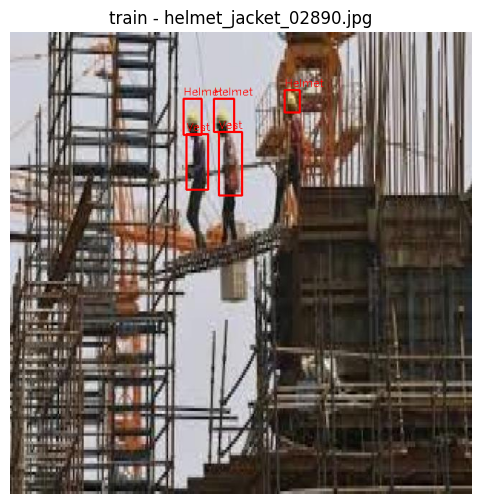

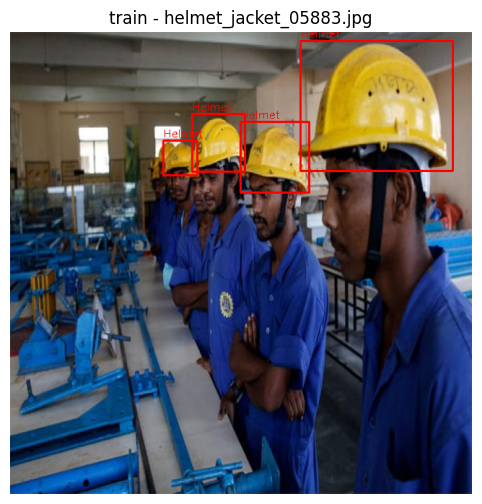


=== VAL ===


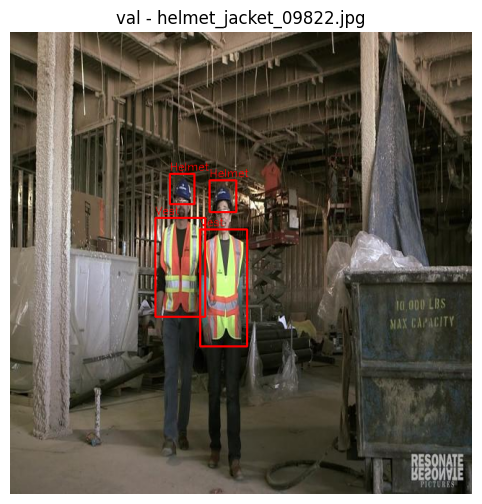

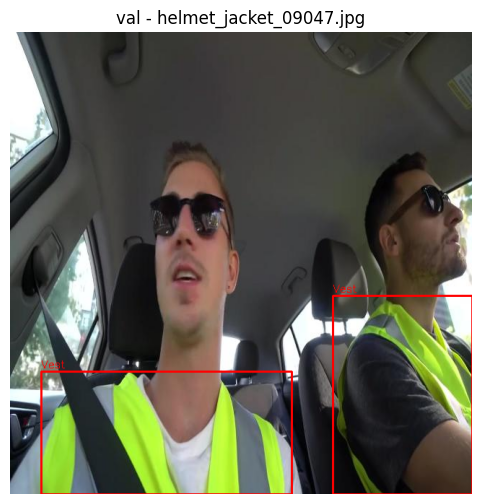


=== TEST ===


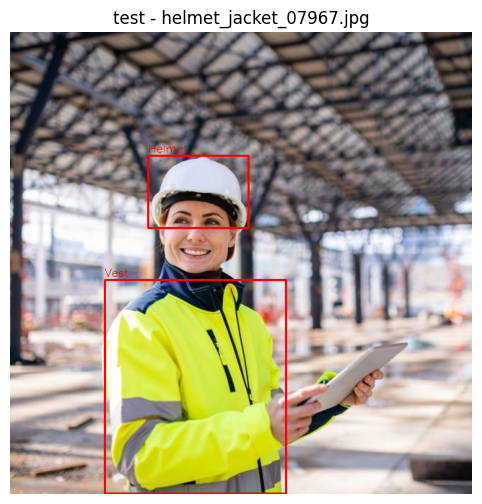

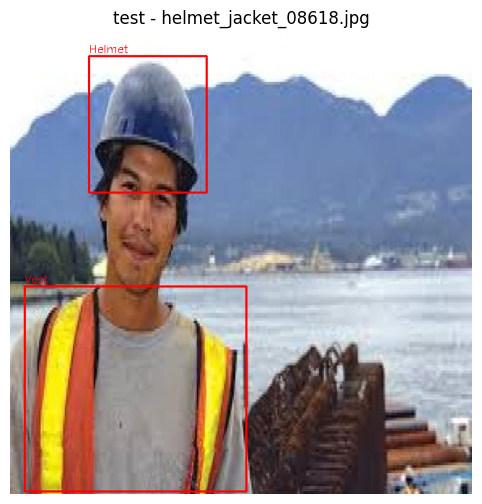

In [8]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import yaml

# Load class names from data.yaml
yaml_path = "/kaggle/working/datasets/ppe_clean/data.yaml"
with open(yaml_path) as f:
    data_yaml = yaml.safe_load(f)

class_names = data_yaml['names']
base_path = "/kaggle/working/datasets/ppe_clean"
splits = ["train", "val", "test"]

for split in splits:
    print(f"\n=== {split.upper()} ===")
    
    images_path = os.path.join(base_path, "images", split if split != "val" else "valid")
    labels_path = os.path.join(base_path, "labels", split if split != "val" else "valid")
    
    # Pick 2 random images
    sample_imgs = random.sample(os.listdir(images_path), 2)
    
    for img_file in sample_imgs:
        img_path = os.path.join(images_path, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Corresponding YOLO label file
        label_file = os.path.join(labels_path, img_file.rsplit(".",1)[0]+".txt")
        boxes = []
        
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                for line in f.readlines():
                    cls_id, x_c, y_c, bw, bh = map(float, line.strip().split())
                    x1 = int((x_c - bw/2) * w)
                    y1 = int((y_c - bh/2) * h)
                    x2 = int((x_c + bw/2) * w)
                    y2 = int((y_c + bh/2) * h)
                    boxes.append((int(cls_id), x1, y1, x2, y2))
        
        # Draw boxes
        for cls_id, x1, y1, x2, y2 in boxes:
            cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
            cv2.putText(img, class_names[cls_id], (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
        
        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{split} - {img_file}")
        plt.show()


In [14]:
#!pip install ultralytics -q
#from ultralytics import YOLO

In [15]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

model.train(
    data="/kaggle/working/datasets/ppe_clean/data.yaml",
    epochs = 30,      
    imgsz = 640,      
    batch = 16,       
    name = "ppe_model" 
)


Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/datasets/ppe_clean/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ppe_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1575       5292      0.927      0.925      0.969      0.792
                Helmet       1290       2966       0.94      0.935      0.975      0.793
                  Vest       1317       2326      0.914      0.916      0.962      0.792
Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/runs/detect/ppe_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f4a6eb3d8d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [16]:
import shutil
import os

source_dir = "/kaggle/working/runs/detect/ppe_model/weights"
dest_dir = "/kaggle/working/saved_models"

os.makedirs(dest_dir, exist_ok=True)

shutil.copy(f"{source_dir}/best.pt", f"{dest_dir}/ppe_best.pt")
shutil.copy(f"{source_dir}/last.pt", f"{dest_dir}/ppe_last.pt")

print("Model saved successfully to:", dest_dir)


Model saved successfully to: /kaggle/working/saved_models


In [18]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/runs/detect/ppe_model/weights/best.pt")

results = model.val()       # Recompute metrics
results_dict = results.results_dict

results_dict


Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,358 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 889.3±315.5 MB/s, size: 44.0 KB)
val: Scanning /kaggle/working/datasets/ppe_clean/labels/valid.cache... 1575 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1575/1575 3.2Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 99/99 4.7it/s 21.3s0.2ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       1575       5292      0.927      0.925      0.969      0.793
                Helmet       1290       2966       0.94      0.935      0.975      0.794
                  Vest       1317       2326      0.914      0.916      0.962      0.792
Speed: 0.9ms preprocess, 9.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/val


{'metrics/precision(B)': 0.9270182417988079,
 'metrics/recall(B)': 0.9252378978977585,
 'metrics/mAP50(B)': 0.9685048418703839,
 'metrics/mAP50-95(B)': 0.7928542703549947,
 'fitness': 0.7928542703549947}

In [19]:
import json

performance_path = "/kaggle/working/performance_file.json"

with open(performance_path, "w") as f:
    json.dump(results_dict, f, indent=4)

print("Performance saved to:", performance_path)


Performance saved to: /kaggle/working/performance_file.json


In [20]:
perf_text_path = "/kaggle/working/performance_file.txt"

with open(perf_text_path, "w") as f:
    f.write("PPE Detection Model – Performance Summary\n")
    f.write("=========================================\n")
    for k, v in results_dict.items():
        f.write(f"{k}: {v}\n")

print("Text performance file saved:", perf_text_path)


Text performance file saved: /kaggle/working/performance_file.txt


In [21]:
portfolio_path = "/kaggle/working/performance_portfolio.txt"

with open(portfolio_path, "w") as f:
    f.write("PPE Helmet & Vest Detection Model – Metrics Summary\n")
    f.write("====================================================\n\n")
    f.write("Model: YOLOv8s (fine-tuned)\n")
    f.write("Classes: Helmet (0), Vest (1)\n\n")
    f.write("Performance:\n")
    f.write(f"  Precision:        {results_dict['metrics/precision(B)']:.4f}\n")
    f.write(f"  Recall:           {results_dict['metrics/recall(B)']:.4f}\n")
    f.write(f"  mAP@50:           {results_dict['metrics/mAP50(B)']:.4f}\n")
    f.write(f"  mAP@50–95:        {results_dict['metrics/mAP50-95(B)']:.4f}\n")
    f.write(f"  Fitness Score:    {results_dict['fitness']:.4f}\n\n")
    f.write("This model can be used for real-time PPE compliance monitoring.\n")

print("Portfolio file saved:", portfolio_path)


Portfolio file saved: /kaggle/working/performance_portfolio.txt


In [24]:
import os

dataset_path = "/kaggle/working"

print("=== DIRECTORY TREE (FOLDERS ONLY) ===\n")

for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, "").count(os.sep)
    indent = " " * 5 * level
    print(f"{indent}{os.path.basename(root)}/")
    for d in dirs:
        subindent = " " * 5 * (level + 1)
        print(f"{subindent}{d}/")


=== DIRECTORY TREE (FOLDERS ONLY) ===

working/
     runs/
     datasets/
     saved_models/
     .virtual_documents/
     runs/
          detect/
          detect/
               ppe_model/
               val/
               ppe_model/
                    weights/
                    weights/
               val/
     datasets/
          ppe_clean/
          ppe/
          ppe_clean/
               images/
               labels/
               images/
                    test/
                    valid/
                    train/
                    test/
                    valid/
                    train/
               labels/
                    test/
                    valid/
                    train/
                    test/
                    valid/
                    train/
          ppe/
               test/
               valid/
               train/
               test/
               valid/
               train/
     saved_models/
     .virtual_documents/
